In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import models
from glob import glob
import cv2
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation, RotationSpline
import open3d as o3d
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def FileLoader(preprocess=None):
    def innner(func):
        class Loader():
            def __init__(self, files):
                self.files = files
            def __getitem__(self, idx):
                if preprocess:
                    return preprocess(func(self.files[idx]))
                return func(self.files[idx])
            def __len__(self):
                return len(self.files)        
        def wrapper_func(glob_folder):
            files = sorted(glob(glob_folder))
            return Loader(files)
        return wrapper_func
    return innner

In [3]:
from torchvision.io import read_image
@FileLoader(preprocess = lambda x : cv2.cvtColor(x, cv2.COLOR_BGR2GRAY))
def RGBImageLoader(x):
    return cv2.imread(x)

In [4]:
rgbloader = RGBImageLoader('/media/kbuyukburc/DATASET/kitti-odo/data_odometry_color/dataset/sequences/00/image_2/*')
len(rgbloader)
rgbloader[100]

array([[ 28,  27,  27, ..., 255, 253, 247],
       [ 28,  27,  27, ..., 254, 247, 233],
       [ 31,  29,  29, ..., 251, 246, 233],
       ...,
       [ 54,  54,  55, ...,  17,  16,  16],
       [ 64,  65,  64, ...,  16,  15,  16],
       [ 75,  76,  77, ...,  16,  15,  15]], dtype=uint8)

In [5]:
def tensorifyIMG(img : np.ndarray):
    img = np.transpose(img, axes=[2,0,1]) / 255    
    return img

def randomTransformation(max_rot = 5, max_tra = 0.5):
    rotation_rnd = (np.random.random(3) - 0.5) * 2 * max_rot * np.pi / 180
    translation_rnd = (np.random.random(3) - 0.5) * 2 * max_tra
    extrinsic = np.eye(4)
    extrinsic[:3,:3] = Rotation.from_rotvec(rotation_rnd).as_matrix()
    extrinsic[:3, 3] = translation_rnd
    extrinsic_inv = np.linalg.inv(extrinsic)
    rotation_inv = Rotation.from_matrix(extrinsic_inv[:3, :3]).as_rotvec()
    translation_inv = extrinsic_inv[:3, 3]
    return extrinsic, np.r_[rotation_inv, translation_inv]

class FusionDataset(Dataset):
    def __init__(self, camera_dataset, 
                lidar_dataset, 
                intrinsic,
                distortion,
                extrinsic,
                tensor_shape = (512, 512)                
                ):
        super().__init__()
        self.camera = camera_dataset
        self.lidar = lidar_dataset
        self.intrinsic = intrinsic
        self.distortion = distortion
        self.extrinsic = extrinsic # Lidar To Camera        
        self.tensor_shape = tensor_shape
        assert len(self.camera) == len(self.lidar), "Dataset length are not matching."

    def __len__(self):
        return len(self.camera)

    def projectDepth(self, pointcloud, intrinsic, smooth = False):
        points_3d = np.asarray(pointcloud.points)
        zero_vec = np.array([0,0,0], dtype=np.float32)
        points_img, _ =  cv2.projectPoints(points_3d, zero_vec, zero_vec, 
                    intrinsic, self.distortion)
        
        points_img = points_img[:, 0, :]
        points_img_flag = (points_img[:, 1] > 0) & (points_img[:, 1] < self.tensor_shape[0]) & \
            (points_img[:, 0] > 0) & (points_img[:, 0] < self.tensor_shape[1]) & \
                (points_3d[:, 2] > 0)
        points_3d_flaged = points_3d[points_img_flag]
        points_img_flaged = points_img[points_img_flag]
        points_3d_norm = np.linalg.norm(points_3d_flaged, axis=1)
        
        ind = np.argsort(points_3d_norm)[::-1]
        points_img_sorted = points_img_flaged[ind]
        points_img_sorted = points_img_sorted.astype(int)
        points_3d_flaged_sorted = points_3d_flaged[ind]

        depth = np.zeros((1, *self.tensor_shape), dtype=np.float32)
        depth[0, points_img_sorted[:, 1], points_img_sorted[:, 0]] = points_3d_flaged_sorted[:, 2]
        if smooth:
            depth_smooth = cv2.GaussianBlur(depth, (15,15), 0)
            return depth_smooth
        return depth

    def __getitem__(self, index):
        img = self.camera[index]
        h, w = img.shape[:2]
        img_resize = cv2.resize(img, self.tensor_shape)        
        intrinsic = self.intrinsic.copy()
        # print(intrinsic)
        intrinsic[0] *= (self.tensor_shape[0]/w)
        intrinsic[1] *= (self.tensor_shape[1]/h)
        # print(intrinsic)
        
        pointcloud : o3d.geometry.PointCloud = self.lidar[index]
        pointcloud.transform(self.extrinsic)
        depth_gt = self.projectDepth(pointcloud, intrinsic, True)
        miss_calibration, miss_pose = randomTransformation()
        pointcloud.transform(miss_calibration)
        depth = self.projectDepth(pointcloud, intrinsic)
        return {'img' : tensorifyIMG(img_resize).astype(np.float32),
                'depth': depth.astype(np.float32),
                'depth_gt': depth_gt.astype(np.float32),
                'extrinsic': miss_calibration.astype(np.float32),
                'intrinsic': intrinsic.astype(np.float32),
                'pose' : miss_pose.astype(np.float32)
            }

In [6]:
@FileLoader()
def RGBImageLoader(x):
    return cv2.imread(x)
cam2 = RGBImageLoader('/media/kbuyukburc/DATASET/kitti-odo/data_odometry_color/dataset/sequences/00/image_2/*')

@FileLoader()
def PCDLoader(x):
    bin = np.fromfile(x, dtype=np.float32).reshape(-1, 4)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(bin[:, :3])
    pcd.colors = o3d.utility.Vector3dVector(np.c_[bin[:, 3], bin[:, 3], bin[:, 3]])
    return pcd
lidar1 = PCDLoader('/media/kbuyukburc/DATASET/kitti-odo/data_odometry_velodyne/dataset/sequences/00/velodyne/*')

In [7]:
intrinsic = np.array([[718.856 ,   0.    , 607.1928],
       [  0.    , 718.856 , 185.2157],
       [  0.    ,   0.    ,   1.    ]])
distortion = np.array([0,0,0,0,0.])
rotvec_gt = np.asarray([ 1.20875812, -1.21797831, 1.19949], dtype="float32")  
tvec_gt = np.asarray([0.05114661, -0.05403985, -0.29219686], dtype="float32")
extrinsic = np.eye(4)
extrinsic[:3, :3] = Rotation.from_rotvec(rotvec_gt).as_matrix()
extrinsic[:3, 3] = tvec_gt
dataset = FusionDataset(camera_dataset=cam2, lidar_dataset=lidar1,
              intrinsic=intrinsic, distortion=distortion,
              extrinsic=extrinsic
            )
print(dataset[0]['img'].shape)

(3, 512, 512)


In [8]:
img = cam2[0]
pointcloud = lidar1[0]
o3d.visualization.draw_geometries([pointcloud])
pointcloud.transform(extrinsic)
h, w = img.shape[:2]        
tensor_shape = (512,512)
img_resize = cv2.resize(img, tensor_shape)        
intrinsic_down = intrinsic.copy()
points_3d = np.asarray(pointcloud.points)
zero_vec = np.array([0,0,0], dtype=np.float32)
points_img, _ =  cv2.projectPoints(points_3d, zero_vec, zero_vec, 
            intrinsic_down, distortion)

points_img = points_img[:, 0, :]
points_img_flag = (points_img[:, 1] > 0) & (points_img[:, 1] < tensor_shape[0]) & \
    (points_img[:, 0] > 0) & (points_img[:, 0] < tensor_shape[1]) & \
        (points_3d[:, 2] > 0)
points_3d_flaged = points_3d[points_img_flag]
points_img_flaged = points_img[points_img_flag]
points_3d_norm = np.linalg.norm(points_3d_flaged, axis=1)

ind = np.argsort(points_3d_norm)[::-1]
points_img_sorted = points_img_flaged[ind]
points_img_sorted = points_img_sorted.astype(int)
points_3d_flaged_sorted = points_3d_flaged[ind]

depth = np.zeros((1, *tensor_shape), dtype=np.float32)
depth[0, points_img_sorted[:, 1], points_img_sorted[:, 0]] = points_3d_flaged_sorted[:, 2]#points_3d_norm


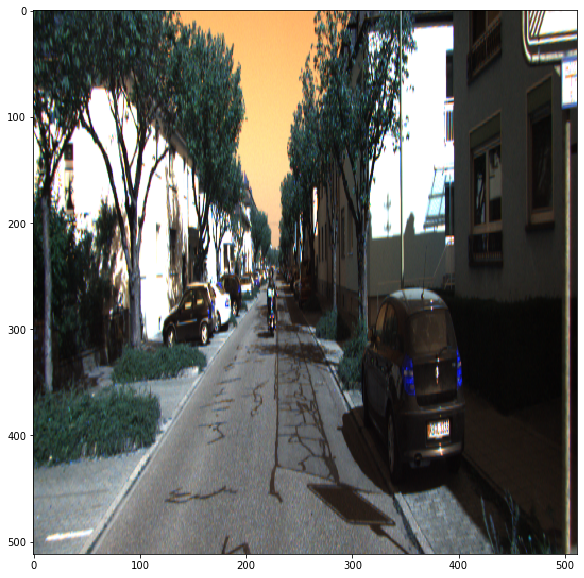

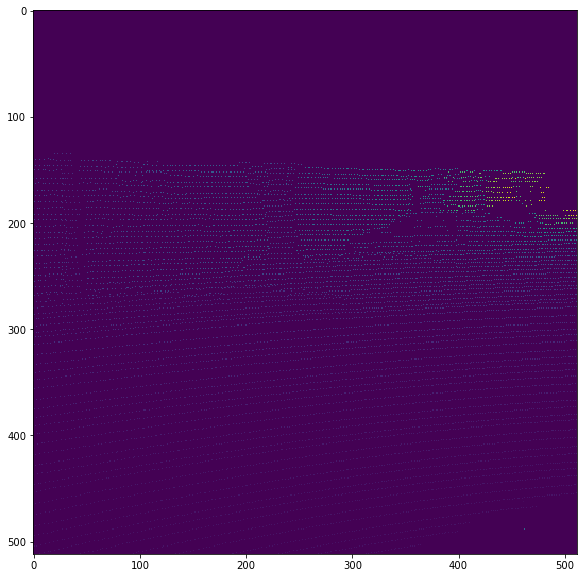

In [9]:
plt.figure(figsize=[10,10])
plt.imshow(img_resize)
plt.figure(figsize=[10,10])
plt.imshow(depth[0])

0.27619934

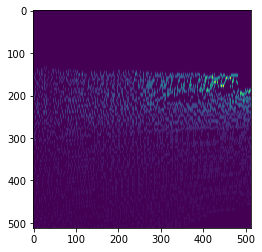

In [10]:
depth_smooth = cv2.GaussianBlur(depth, (15,15), 0)
plt.imshow(depth_smooth[0])
(depth_smooth - depth).sum()

In [11]:
class DatasetMerger:
    def __init__(self, *args):
        self.dataset_list = [*args]
        self.datset_length = [len(dataset) for dataset in self.dataset_list]
        self.dataset_edge = [0]
        for dataset in self.dataset_list:
            self.dataset_edge.append(len(dataset)+self.dataset_edge[-1])
        self.length = self.dataset_edge[-1]
    
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        assert idx >= 0 and idx < len(self), "Out of range"
        for id, dataset in enumerate(self.dataset_list):
            if self.dataset_edge[id+1] > idx >= self.dataset_edge[id]:
                return dataset[idx-self.dataset_edge[id]]
        raise('Something went wrong!')

class DatasetSequencer:
    def __init__(self, dataset, sequence_length = 10):
        self.dataset = dataset
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.dataset) // self.sequence_length

    def __getitem__(self, idx):
        assert idx >= 0 and idx < len(self), "Out of range"
        index = idx * self.sequence_length
        batch_data = self.dataset[index]
        if isinstance(batch_data, np.ndarray):
            data_shape = batch_data.shape
            batch_data = batch_data[None, ...]
            for num in range(1, self.sequence_length):
                data =  self.dataset[index+num]
                assert data_shape == data.shape, "Data Shape not matching"
                batch_data = np.append(batch_data, data[None, ...], axis=0)
        elif isinstance(batch_data, dict):
            data_shape = {key : data.shape for key, data in batch_data.items()}
            batch_data = {key : data[None, ...] for key, data in batch_data.items()}
            for num in range(1, self.sequence_length):
                data =  self.dataset[index+num]
                for key in batch_data.keys():
                    assert data_shape[key] == data[key].shape, "Data Shape not matching"
                    batch_data[key] = np.append(batch_data[key], data[key][None, ...], axis=0)
        else:
            raise('Hmmm! we werent expecting this case =/.')


        return batch_data

class FusionDatasetV2(Dataset):
    def __init__(self, camera_dataset, 
                lidar_dataset, 
                intrinsic,
                distortion,
                extrinsic,
                tensor_shape = (512, 512)                
                ):
        super().__init__()
        self.camera = camera_dataset
        self.lidar = lidar_dataset
        self.intrinsic = intrinsic
        self.distortion = distortion
        self.extrinsic = extrinsic # Lidar To Camera        
        self.tensor_shape = tensor_shape
        assert len(self.camera) == len(self.lidar), "Dataset length are not matching."

    def __len__(self):
        return len(self.camera)

    def projectDepth(self, pointcloud, intrinsic, smooth = False):
        points_3d = np.asarray(pointcloud.points)
        zero_vec = np.array([0,0,0], dtype=np.float32)
        points_img, _ =  cv2.projectPoints(points_3d, zero_vec, zero_vec, 
                    intrinsic, self.distortion)
        
        points_img = points_img[:, 0, :]
        points_img_flag = (points_img[:, 1] > 0) & (points_img[:, 1] < self.tensor_shape[0]) & \
            (points_img[:, 0] > 0) & (points_img[:, 0] < self.tensor_shape[1]) & \
                (points_3d[:, 2] > 0)
        points_3d_flaged = points_3d[points_img_flag]
        points_img_flaged = points_img[points_img_flag]
        points_3d_norm = np.linalg.norm(points_3d_flaged, axis=1)
        
        ind = np.argsort(points_3d_norm)[::-1]
        points_img_sorted = points_img_flaged[ind]
        points_img_sorted = points_img_sorted.astype(int)
        points_3d_flaged_sorted = points_3d_flaged[ind]

        depth = np.zeros((1, *self.tensor_shape), dtype=np.float32)
        depth[0, points_img_sorted[:, 1], points_img_sorted[:, 0]] = points_3d_flaged_sorted[:, 2]
        if smooth:
            depth_smooth = cv2.GaussianBlur(depth, (15,15), 0)
            return depth_smooth
        return depth

    def __getitem__(self, index):
        if isinstance(index, tuple):
            index, miss_calibration, miss_pose = index
        else:
            miss_calibration = np.eye(4); miss_pose = np.zeros(6)            
            
        img = self.camera[index]
        h, w = img.shape[:2]
        img_resize = cv2.resize(img, self.tensor_shape)        
        intrinsic = self.intrinsic.copy()
        # print(intrinsic)
        intrinsic[0] *= (self.tensor_shape[0]/w)
        intrinsic[1] *= (self.tensor_shape[1]/h)
        # print(intrinsic)
        
        pointcloud : o3d.geometry.PointCloud = self.lidar[index]
        pointcloud.transform(self.extrinsic)
        depth_gt = self.projectDepth(pointcloud, intrinsic, True)
        # miss_calibration, miss_pose = randomTransformation()
        pointcloud.transform(miss_calibration)
        depth = self.projectDepth(pointcloud, intrinsic)
        return {'img' : tensorifyIMG(img_resize).astype(np.float32),
                'depth': depth.astype(np.float32),
                'depth_gt': depth_gt.astype(np.float32),
                'extrinsic': miss_calibration.astype(np.float32),
                'intrinsic': intrinsic.astype(np.float32),
                'pose' : miss_pose.astype(np.float32)
            }


class DatasetBatchSequencer:
    def __init__(self, dataset, sequence_length = 4):
        self.dataset = dataset
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.dataset) // self.sequence_length

    def __getitem__(self, idx):
        assert idx >= 0 and idx < len(self), "Out of range"
        index = idx * self.sequence_length        
        batch_data = self.dataset[index]
        if isinstance(batch_data, np.ndarray):
            data_shape = batch_data.shape
            batch_data = batch_data[None, ...]
            for num in range(1, self.sequence_length):
                data =  self.dataset[index+num]
                assert data_shape == data.shape, "Data Shape not matching"
                batch_data = np.append(batch_data, data[None, ...], axis=0)
        elif isinstance(batch_data, dict):
            miss_calibration, miss_pose = randomTransformation()
            batch_data = self.dataset[index, miss_calibration, miss_pose]
            data_shape = {key : data.shape for key, data in batch_data.items()}
            batch_data = {key : data[None, ...] for key, data in batch_data.items()}            
            for num in range(1, self.sequence_length):                
                data =  self.dataset[index+num, miss_calibration, miss_pose]
                for key in batch_data.keys():
                    assert data_shape[key] == data[key].shape, "Data Shape not matching"
                    batch_data[key] = np.append(batch_data[key], data[key][None, ...], axis=0)
        else:
            raise('Hmmm! we werent expecting this case =/.')


        return batch_data

In [12]:
mergedset = DatasetMerger(cam2, lidar1)
print(len(cam2), len(lidar1), len(mergedset))
print(type(mergedset[0]), type(mergedset[9081]))

4541 4541 9082
<class 'numpy.ndarray'> <class 'open3d.cuda.pybind.geometry.PointCloud'>


In [13]:
sqset = DatasetSequencer(dataset=cam2, sequence_length=10)
print(len(sqset))
print(sqset[0].shape)
print(sqset[453].shape)
seqset = DatasetSequencer(dataset=dataset, sequence_length=10)
print(seqset[0]['img'].shape)

454
(10, 376, 1241, 3)
(10, 376, 1241, 3)
(10, 3, 512, 512)


In [14]:
from os import path
def load_kitti_calib(filename):
    filedata = {}
    data = {}
    with open(filename) as f:
        for line in f.readlines():
            key, value = line.split(':', 1)
            # The only non-float values in these files are dates, which
            # we don't care about anyway
            try:
                filedata[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass
    # Create 3x4 projection matrices
    P_rect_00 = np.reshape(filedata['P0'], (3, 4))
    P_rect_10 = np.reshape(filedata['P1'], (3, 4))
    P_rect_20 = np.reshape(filedata['P2'], (3, 4))
    P_rect_30 = np.reshape(filedata['P3'], (3, 4))

    data['P_rect_00'] = P_rect_00
    data['P_rect_10'] = P_rect_10
    data['P_rect_20'] = P_rect_20
    data['P_rect_30'] = P_rect_30

    # Compute the rectified extrinsics from cam0 to camN
    T1 = np.eye(4)
    T1[0, 3] = P_rect_10[0, 3] / P_rect_10[0, 0]
    T2 = np.eye(4)
    T2[0, 3] = P_rect_20[0, 3] / P_rect_20[0, 0]
    T3 = np.eye(4)
    T3[0, 3] = P_rect_30[0, 3] / P_rect_30[0, 0]

    # Compute the velodyne to rectified camera coordinate transforms
    data['T_cam0_velo'] = np.reshape(filedata['Tr'], (3, 4))
    data['T_cam0_velo'] = np.vstack([data['T_cam0_velo'], [0, 0, 0, 1]])
    data['T_cam1_velo'] = T1.dot(data['T_cam0_velo'])
    data['T_cam2_velo'] = T2.dot(data['T_cam0_velo'])
    data['T_cam3_velo'] = T3.dot(data['T_cam0_velo'])

    # Compute the camera intrinsics
    data['K_cam0'] = P_rect_00[0:3, 0:3]
    data['K_cam1'] = P_rect_10[0:3, 0:3]
    data['K_cam2'] = P_rect_20[0:3, 0:3]
    data['K_cam3'] = P_rect_30[0:3, 0:3]

    # Compute the stereo baselines in meters by projecting the origin of
    # each camera frame into the velodyne frame and computing the distances
    # between them
    p_cam = np.array([0, 0, 0, 1])
    p_velo0 = np.linalg.inv(data['T_cam0_velo']).dot(p_cam)
    p_velo1 = np.linalg.inv(data['T_cam1_velo']).dot(p_cam)
    p_velo2 = np.linalg.inv(data['T_cam2_velo']).dot(p_cam)
    p_velo3 = np.linalg.inv(data['T_cam3_velo']).dot(p_cam)

    data['b_gray'] = np.linalg.norm(p_velo1 - p_velo0)  # gray baseline
    data['b_rgb'] = np.linalg.norm(p_velo3 - p_velo2)   # rgb baseline

    return data        

In [15]:
from os import path
root_folder = '/media/kbuyukburc/DATASET/kitti-odo/'
class KITTIDatset(DatasetMerger):
    def __init__(self, root_folder : str, sequence : str):        
        self.cam2 = RGBImageLoader(path.join(root_folder, f'data_odometry_color/dataset/sequences/{sequence}/image_2/*'))
        self.cam3 = RGBImageLoader(path.join(root_folder, f'data_odometry_color/dataset/sequences/{sequence}/image_3/*'))
        self.lidar1 = PCDLoader(path.join(root_folder, f'data_odometry_velodyne/dataset/sequences/{sequence}/velodyne/*'))
        self.calib = load_kitti_calib(path.join(root_folder, f'data_odometry_calib/dataset/sequences/{sequence}/calib.txt'))
        distortion = np.array([0,0,0,0,0.])
        self.dataset_1 = DatasetSequencer(FusionDataset(camera_dataset=self.cam2, lidar_dataset=self.lidar1,
              intrinsic=self.calib['K_cam2'], distortion=distortion,
              extrinsic=self.calib['T_cam2_velo']
            ), sequence_length=10)
        self.dataset_2 = DatasetSequencer(FusionDataset(camera_dataset=self.cam3, lidar_dataset=self.lidar1,
              intrinsic=self.calib['K_cam3'], distortion=distortion,
              extrinsic=self.calib['T_cam3_velo']
            ), sequence_length=10)
        DatasetMerger.__init__(self, self.dataset_1, self.dataset_2)
      
      
from os import path
root_folder = '/media/kbuyukburc/DATASET/kitti-odo/'
class KITTIDatsetV2(DatasetMerger):
    def __init__(self, root_folder : str, sequence : str):        
        self.cam2 = RGBImageLoader(path.join(root_folder, f'data_odometry_color/dataset/sequences/{sequence}/image_2/*'))
        self.cam3 = RGBImageLoader(path.join(root_folder, f'data_odometry_color/dataset/sequences/{sequence}/image_3/*'))
        self.lidar1 = PCDLoader(path.join(root_folder, f'data_odometry_velodyne/dataset/sequences/{sequence}/velodyne/*'))
        self.calib = load_kitti_calib(path.join(root_folder, f'data_odometry_calib/dataset/sequences/{sequence}/calib.txt'))
        distortion = np.array([0,0,0,0,0.])
        self.dataset_1 = DatasetBatchSequencer(FusionDatasetV2(camera_dataset=self.cam2, lidar_dataset=self.lidar1,
              intrinsic=self.calib['K_cam2'], distortion=distortion,
              extrinsic=self.calib['T_cam2_velo']
            ), sequence_length=10)
        self.dataset_2 = DatasetBatchSequencer(FusionDatasetV2(camera_dataset=self.cam3, lidar_dataset=self.lidar1,
              intrinsic=self.calib['K_cam3'], distortion=distortion,
              extrinsic=self.calib['T_cam3_velo']
            ), sequence_length=10)
        DatasetMerger.__init__(self, self.dataset_1, self.dataset_2)
      
      


In [16]:
kittiset = KITTIDatsetV2(root_folder, '00')
kittiset[0]['img'].shape

(10, 3, 512, 512)

In [17]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(kittiset, batch_size=4, shuffle=True, num_workers=6)
it = iter(train_dataloader)
data_batch = next(it)

In [18]:
data_batch.keys()

dict_keys(['img', 'depth', 'depth_gt', 'extrinsic', 'intrinsic', 'pose'])

In [19]:
import torch.nn as nn
class CalibResnet(nn.Module):
    def __init__(self, in_channels = 1, num_layer = 3):
        super().__init__()
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        self.model = models.resnet18(weights=weights)
        self.num_layer = num_layer
        self.model.conv1 = nn.Conv2d(in_channels = in_channels, 
            out_channels = self.model.conv1.out_channels,
            kernel_size = self.model.conv1.kernel_size,
            stride = self.model.conv1.stride,
            padding = self.model.conv1.padding,
            bias = self.model.conv1.bias
            )

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        if self.num_layer >= 1:
            x = self.model.layer1(x)
        if self.num_layer >= 2:
            x = self.model.layer2(x)
        if self.num_layer >= 3:
            x = self.model.layer3(x)
        if self.num_layer >= 4:
            x = self.model.layer4(x)
        return x
        # x = self.model.avgpool(x)
        # x = torch.flatten(x, 1)
        # x = self.model.fc(x)

class CalibNet(nn.Module):
    def __init__(self):
        super().__init__()
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        self.camera_model = CalibResnet(in_channels=3)
        self.lidar_model = CalibResnet(in_channels=1)
        self.conv1 = nn.Conv2d(in_channels = 512, 
            out_channels = 1024, kernel_size=4)
        self.conv2 = nn.Conv2d(in_channels = 1024, 
            out_channels = 2048, kernel_size=4)
        self.avg1 = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc1 = nn.Linear(2048, 6)

    def forward(self, x_img, x_depth):
        x_img = self.camera_model(x_img)
        x_depth = self.lidar_model(x_depth)
        x_out = torch.cat([x_img, x_depth], dim=1)
        x_out = self.conv1(x_out)
        x_out = self.conv2(x_out)
        x_out = self.avg1(x_out)
        x_out = x_out.flatten(1)
        x_out = self.fc1(x_out)
        return x_out
        

# Transformation

In [20]:
import kornia.geometry as K
def rtvec_to_matrix(rtvec):
    B, C = rtvec.shape
    extrinsic = torch.eye(4).unsqueeze(0).repeat(B,1,1).to(rtvec.device)
    extrinsic[:, :3, :3] = K.conversions.angle_axis_to_rotation_matrix(rtvec[:, :3])
    extrinsic[:, :3, 3] = rtvec[:, 3:]
    return extrinsic

def matrix_to_rtvec(extrinsic):
    B, C1, C2 = extrinsic.shape
    rtvec = torch.zeros(B, 6).to(extrinsic.device)
    rtvec[:, :3] = K.conversions.rotation_matrix_to_angle_axis(extrinsic[:, :3, :3].contiguous())
    rtvec[:, 3:] = extrinsic[:, :3, 3]
    return rtvec

rtvec_rnd = torch.rand(8,6, requires_grad=True)
print(rtvec_rnd)
matrix_to_rtvec(rtvec_to_matrix(rtvec_rnd))


tensor([[0.9770, 0.3364, 0.1191, 0.7606, 0.4440, 0.6567],
        [0.5566, 0.1620, 0.9668, 0.8360, 0.8644, 0.8502],
        [0.6895, 0.1595, 0.3530, 0.6286, 0.5707, 0.8162],
        [0.5650, 0.9852, 0.2124, 0.1170, 0.2773, 0.3992],
        [0.4164, 0.2467, 0.7095, 0.5044, 0.7218, 0.2796],
        [0.3504, 0.1465, 0.7006, 0.8894, 0.2679, 0.7459],
        [0.3105, 0.3585, 0.3496, 0.8134, 0.7934, 0.7291],
        [0.3755, 0.2285, 0.3684, 0.0076, 0.5663, 0.6590]], requires_grad=True)


tensor([[0.9770, 0.3364, 0.1191, 0.7606, 0.4440, 0.6567],
        [0.5566, 0.1620, 0.9668, 0.8360, 0.8644, 0.8502],
        [0.6895, 0.1595, 0.3530, 0.6286, 0.5707, 0.8162],
        [0.5650, 0.9852, 0.2124, 0.1170, 0.2773, 0.3992],
        [0.4164, 0.2467, 0.7095, 0.5044, 0.7218, 0.2796],
        [0.3504, 0.1465, 0.7006, 0.8894, 0.2679, 0.7459],
        [0.3105, 0.3585, 0.3496, 0.8134, 0.7934, 0.7291],
        [0.3755, 0.2285, 0.3684, 0.0076, 0.5663, 0.6590]],
       grad_fn=<CopySlices>)

In [21]:
matrix_to_rtvec(rtvec_to_matrix(rtvec_rnd.cuda()))

tensor([[0.9770, 0.3364, 0.1191, 0.7606, 0.4440, 0.6567],
        [0.5566, 0.1620, 0.9668, 0.8360, 0.8644, 0.8502],
        [0.6895, 0.1595, 0.3530, 0.6286, 0.5707, 0.8162],
        [0.5650, 0.9852, 0.2124, 0.1170, 0.2773, 0.3992],
        [0.4164, 0.2467, 0.7095, 0.5044, 0.7218, 0.2796],
        [0.3504, 0.1465, 0.7006, 0.8894, 0.2679, 0.7459],
        [0.3105, 0.3585, 0.3496, 0.8134, 0.7934, 0.7291],
        [0.3755, 0.2285, 0.3684, 0.0076, 0.5663, 0.6590]], device='cuda:0',
       grad_fn=<CopySlices>)

## Training

In [22]:
import torchgeometry as tgm
from torch import optim
model = CalibNet()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()
model.cuda()

CalibNet(
  (camera_model): CalibResnet(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): B

In [23]:
model = torch.load('vanilla.ckpt')

# Train

In [ ]:
for epoch in range(10):
    loss_list = []
    for data_batch in train_dataloader:
        for key in data_batch.keys():
            data_batch[key] = data_batch[key].cuda()
        model.zero_grad()
        B, S, C, H, W = data_batch['depth'].shape
        calib_out = model(data_batch['img'].view(B*S, 3, H, W), data_batch['depth'].view(B*S, 1, H, W))    
        calib_out_tanh = torch.tanh(calib_out)
        extrinsic_ts = tgm.rtvec_to_pose(calib_out_tanh * torch.pi).view(B,S,4,4)
        B, S, C, H, W = data_batch['depth'].shape
        y = torch.arange(512)
        x = torch.arange(512)
        gridy, gridx = torch.meshgrid(x, y, indexing='ij')
        mask_batch = (data_batch['depth'] < 0.1)
        gridx_batch = gridx.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat([B,S,C,1,1]).cuda()
        gridy_batch = gridy.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat([B,S,C,1,1]).cuda()

        uvz = torch.zeros((B,S,3,512,512), dtype=torch.float32).cuda()
        mask = (data_batch['depth'][0,0] == 0)[0]
        uvz[:,:,0] = (gridx_batch * data_batch['depth'])[:,:,0]
        uvz[:,:,1] = (gridy_batch * data_batch['depth'])[:,:,0]
        uvz[:,:,2] = (data_batch['depth'])[:,:,0]
        points3d = (torch.inverse(data_batch['intrinsic']) @ uvz.reshape(B,S,3,-1))
        points3d_hom = torch.cat((points3d, torch.ones(B, S, 1, points3d.shape[-1]).cuda()),dim=2)
        projected = data_batch['intrinsic'] @ (extrinsic_ts @ points3d_hom)[:,:,:3]
        Z = projected[:,:,2,:]
        Y = projected[:,:,1,:] / Z
        X = projected[:,:,0,:] / Z
        X = X.to(torch.int64); Y = Y.to(torch.int64)
        depth_out = torch.zeros(B, S, C, H, W).cuda()
        flag = (Y < W) & (Y > 0) & (X > 0) & (X < W)
        flag_out_mean = torch.zeros(1).cuda()
        for b in range(B):
            for s in range(S):
                flag_idx = flag[b,s]
                flag_out = Z[b,s,~flag_idx]
                flag_out_mean = flag_out_mean + flag_out.abs().mean()
                depth_out[b,s,0,Y[b, s, flag_idx],X[b,s,flag_idx]] = Z[b,s,flag_idx]
        loss_linear = (data_batch['pose'].view(B*S,6)/torch.pi - calib_out_tanh).abs().mean()
        loss_depth = (data_batch['depth_gt'] - depth_out).abs().mean()
        loss_proj = (1 / (depth_out.mean() + 1e-9)) / 10
        loss_flagout = flag_out_mean / (B*S)
        loss = loss_depth + loss_linear * 20# + loss_flagout  #  + loss_proj
        loss.backward()
        optimizer.step()
        loss_list.append(loss.detach().cpu().numpy())
        print(f'loss : {loss}, linear : {loss_linear}, depth : {loss_depth}, flag_out : {loss_flagout}', end='\r')
    print(f'\n epch : {epoch} loss : {np.array(loss_list).mean()}', end='\n')    

# Validation

In [24]:
def transform_depth(extrinsic_ts):
    B, S, C, H, W = data_batch['depth'].shape
    y = torch.arange(512)
    x = torch.arange(512)
    gridy, gridx = torch.meshgrid(x, y, indexing='ij')
    mask_batch = (data_batch['depth'] < 0.1)
    gridx_batch = gridx.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat([B,S,C,1,1]).cuda()
    gridy_batch = gridy.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat([B,S,C,1,1]).cuda()

    uvz = torch.zeros((B,S,3,512,512), dtype=torch.float32).cuda()
    mask = (data_batch['depth'][0,0] == 0)[0]
    uvz[:,:,0] = (gridx_batch * data_batch['depth'])[:,:,0]
    uvz[:,:,1] = (gridy_batch * data_batch['depth'])[:,:,0]
    uvz[:,:,2] = (data_batch['depth'])[:,:,0]
    points3d = (torch.inverse(data_batch['intrinsic']) @ uvz.reshape(B,S,3,-1))
    points3d_hom = torch.cat((points3d, torch.ones(B, S, 1, points3d.shape[-1]).cuda()),dim=2)
    projected = data_batch['intrinsic'] @ (extrinsic_ts @ points3d_hom)[:,:,:3]
    Z = projected[:,:,2,:]
    Y = projected[:,:,1,:] / Z
    X = projected[:,:,0,:] / Z
    X = X.to(torch.int64); Y = Y.to(torch.int64)
    depth_out = torch.zeros(B, S, C, H, W).cuda()
    flag = (Y < W) & (Y > 0) & (X > 0) & (X < W)
    flag_out_mean = torch.zeros(1).cuda()
    for b in range(B):
        for s in range(S):
            flag_idx = flag[b,s]
            flag_out = Z[b,s,~flag_idx]
            flag_out_mean = flag_out_mean + flag_out.abs().mean()
            depth_out[b,s,0,Y[b, s, flag_idx],X[b,s,flag_idx]] = Z[b,s,flag_idx]
    return depth_out

In [41]:
loss_list = []
extrinsic_predict_np = np.empty([0,6])
extrinsic_gt_np = np.empty([0,6])
model.eval()
for data_batch in train_dataloader:
    for key in data_batch.keys():
        data_batch[key] = data_batch[key].cuda()    
    B, S, C, H, W = data_batch['depth'].shape
    calib_out = model(data_batch['img'].view(B*S, 3, H, W), data_batch['depth'].view(B*S, 1, H, W))    
    calib_out_tanh = torch.tanh(calib_out)
    extrinsic_ts = tgm.rtvec_to_pose(calib_out_tanh * torch.pi).view(B,S,4,4)
    B, S, C, H, W = data_batch['depth'].shape
    y = torch.arange(512)
    x = torch.arange(512)
    gridy, gridx = torch.meshgrid(x, y, indexing='ij')
    mask_batch = (data_batch['depth'] < 0.1)
    gridx_batch = gridx.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat([B,S,C,1,1]).cuda()
    gridy_batch = gridy.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat([B,S,C,1,1]).cuda()

    uvz = torch.zeros((B,S,3,512,512), dtype=torch.float32).cuda()
    mask = (data_batch['depth'][0,0] == 0)[0]
    uvz[:,:,0] = (gridx_batch * data_batch['depth'])[:,:,0]
    uvz[:,:,1] = (gridy_batch * data_batch['depth'])[:,:,0]
    uvz[:,:,2] = (data_batch['depth'])[:,:,0]
    points3d = (torch.inverse(data_batch['intrinsic']) @ uvz.reshape(B,S,3,-1))
    points3d_hom = torch.cat((points3d, torch.ones(B, S, 1, points3d.shape[-1]).cuda()),dim=2)
    projected = data_batch['intrinsic'] @ (extrinsic_ts @ points3d_hom)[:,:,:3]
    Z = projected[:,:,2,:]
    Y = projected[:,:,1,:] / Z
    X = projected[:,:,0,:] / Z
    X = X.to(torch.int64); Y = Y.to(torch.int64)
    depth_out = torch.zeros(B, S, C, H, W).cuda()
    flag = (Y < W) & (Y > 0) & (X > 0) & (X < W)
    flag_out_mean = torch.zeros(1).cuda()
    for b in range(B):
        for s in range(S):
            flag_idx = flag[b,s]
            flag_out = Z[b,s,~flag_idx]
            flag_out_mean = flag_out_mean + flag_out.abs().mean()
            depth_out[b,s,0,Y[b, s, flag_idx],X[b,s,flag_idx]] = Z[b,s,flag_idx]
    loss_linear = (data_batch['pose'].view(B*S,6)/torch.pi - calib_out_tanh).abs().mean()
    loss_depth = (data_batch['depth_gt'] - depth_out).abs().mean()
    loss_proj = (1 / (depth_out.mean() + 1e-9)) / 10
    loss_flagout = flag_out_mean / (B*S)
    loss = loss_depth + loss_linear * 20# + loss_flagout  #  + loss_proj        
    loss_list.append(loss.detach().cpu().numpy())
    print(f'loss : {loss}, linear : {loss_linear}, depth : {loss_depth}, flag_out : {loss_flagout}', end='\r')
    extrinsic_predict_np = np.append(extrinsic_predict_np, (calib_out_tanh*torch.pi).detach().cpu().numpy(), axis=0)
    extrinsic_gt_np = np.append(extrinsic_gt_np, (data_batch['pose'].view(B*S,6)).detach().cpu().numpy(), axis=0)
    #extrinsic_predict_np = np.append(extrinsic_predict_np, extrinsic_ts.reshape(-1,4,4).detach().cpu().numpy(), axis=0)
    #extrinsic_gt_np = np.append(extrinsic_gt_np, data_batch['extrinsic'].reshape(-1,4,4).cpu().numpy(), axis=0)
    break
# print(f'\n epch : {epoch} loss : {np.array(loss_list).mean()}', end='\n')    

In [43]:
calib_out_tanh[3] = calib_out_tanh[0] / 3
calib_out_tanh[6] = calib_out_tanh[6]* 2 / 3
extrinsic_ts = tgm.rtvec_to_pose(calib_out_tanh * torch.pi).view(B,S,4,4)
depth_out = transform_depth(extrinsic_ts)

WARNING - 2023-03-13 23:16:23,532 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


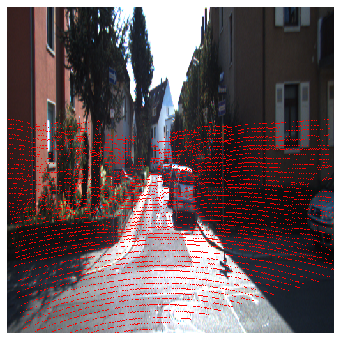

In [63]:
plt.figure(figsize=[6,6])
plt.axis('off')
img = np.transpose(data_batch['img'][0,idx].cpu().numpy(), axes=(1,2,0))[..., ::-1]
depth = depth_out[0,idx,0].detach().cpu().numpy()
depth_smooth = cv2.GaussianBlur(depth, (15,15), 0)
img[depth != 0] = [255,0,0]
plt.imshow(img)

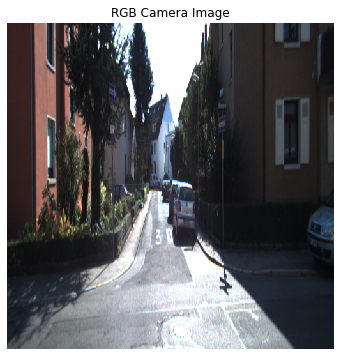

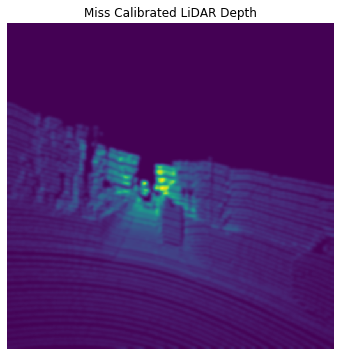

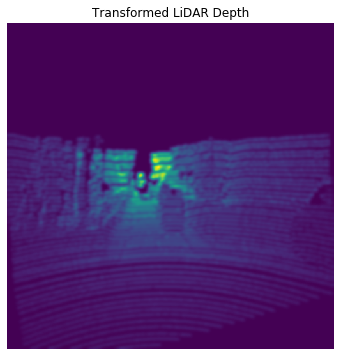

In [62]:
idx = 9
plt.figure(figsize=[6,6])
plt.title('RGB Camera Image')
plt.axis('off')
plt.imshow(np.transpose(data_batch['img'][0,idx].cpu().numpy(), axes=(1,2,0))[..., ::-1])
plt.figure(figsize=[6,6])
plt.title('Miss Calibrated LiDAR Depth')
plt.axis('off')
depth = data_batch['depth'][0,idx,0].cpu().numpy()
depth_smooth = cv2.GaussianBlur(depth, (15,15), 0)
plt.imshow(depth_smooth)
plt.figure(figsize=[6,6])
plt.title('Transformed LiDAR Depth')
plt.axis('off')
depth = depth_out[0,idx,0].detach().cpu().numpy()
depth_smooth = cv2.GaussianBlur(depth, (15,15), 0)
plt.imshow(depth_smooth)

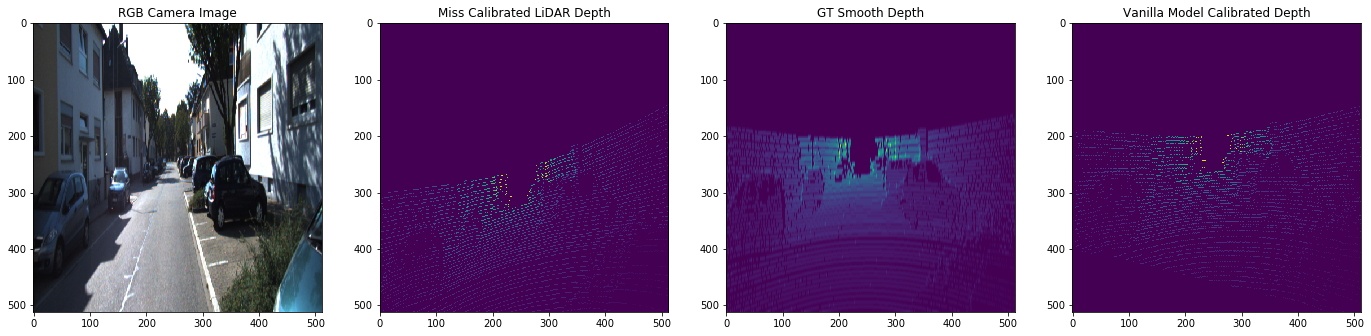

In [35]:
plt.figure(figsize=[30,30])
plt.subplot(151)
plt.title('RGB Camera Image')
plt.imshow(np.transpose(data_batch['img'][0,0].cpu().numpy(), axes=(1,2,0))[..., ::-1])
plt.subplot(152)
plt.title('Miss Calibrated LiDAR Depth')
plt.imshow(data_batch['depth'][0,0,0].cpu().numpy())
plt.subplot(153)
plt.title('GT Smooth Depth')
plt.imshow(data_batch['depth_gt'][0,0,0].cpu().numpy())
plt.subplot(154)
plt.title('Vanilla Model Calibrated Depth')
plt.imshow(depth_out[0,0,0].detach().cpu().numpy())

In [46]:
np.mean(np.abs((extrinsic_gt_np[:, 3:] - extrinsic_predict_np[:, 3:])), axis=1).mean()

0.13994344398427833

(array([ 4., 11.,  7., 12., 13.,  7.,  3., 10.,  9.,  4.]),
 array([0.02703324, 0.05077292, 0.0745126 , 0.09825228, 0.12199196,
        0.14573164, 0.16947132, 0.193211  , 0.21695068, 0.24069036,
        0.26443003]),
 <a list of 10 Patch objects>)

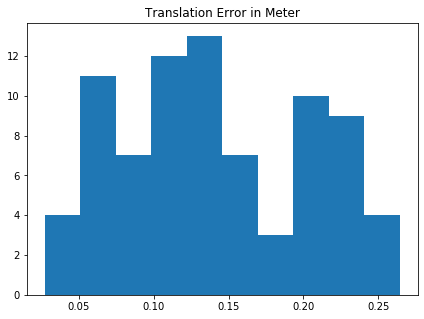

In [47]:
plt.figure(figsize=[7,5])
plt.title('Translation Error in Meter')
plt.hist(np.mean(np.abs((extrinsic_gt_np - extrinsic_predict_np)[:, 3:]), axis=1))

(array([ 347., 1441., 1942., 1821., 1555., 1065.,  590.,  243.,   64.,
          12.]),
 array([0.00030573, 0.00664363, 0.01298153, 0.01931944, 0.02565734,
        0.03199524, 0.03833315, 0.04467105, 0.05100895, 0.05734686,
        0.06368476]),
 <a list of 10 Patch objects>)

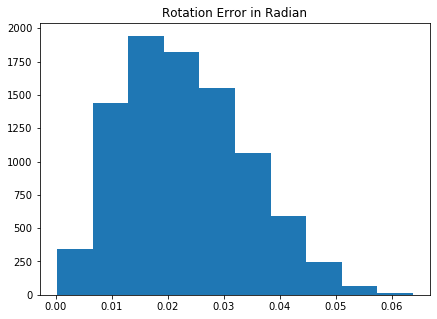

In [43]:
plt.figure(figsize=[7,5])
plt.title('Rotation Error in Radian')
plt.hist(np.mean(np.abs((extrinsic_gt_np - extrinsic_predict_np)[:, :3]), axis=1))

In [48]:
((calib_out_tanh*torch.pi)[:, 3:] - data_batch['pose'].view(B*S,6)[:, 3:]).abs().shape

torch.Size([80, 3])

# Test block

In [27]:
class CalibRNNet(nn.Module):
    def __init__(self):
        super().__init__()
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        self.camera_model = CalibResnet(in_channels=3)
        self.lidar_model = CalibResnet(in_channels=1)
        self.conv1 = nn.Conv2d(in_channels = 512, 
            out_channels = 1024, kernel_size=4)
        self.conv2 = nn.Conv2d(in_channels = 1024, 
            out_channels = 2048, kernel_size=4)
        self.avg1 = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
        self.n_layers = 3
        self.hidden_dim = 4096
        self.rnn = nn.RNN(input_size=2048, hidden_size=self.hidden_dim, batch_first=True, num_layers=self.n_layers)

        self.fc1 = nn.Linear(4096, 128)        
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x_img, x_depth):
        x_img = self.camera_model(x_img)
        x_depth = self.lidar_model(x_depth)
        x_out = torch.cat([x_img, x_depth], dim=1)
        x_out = self.conv1(x_out)
        x_out = self.conv2(x_out)
        x_out = self.avg1(x_out)
        x_out = x_out.flatten(1)
        B, C = x_out.shape
        x_out, self.hidden = self.rnn(x_out.view(B,1,C), self.hidden)
        x_out = self.fc1(x_out)
        x_out = self.fc2(x_out)
        return x_out.flatten(1)
    
    def reset_hidden(self, B):
        self.hidden = torch.zeros(self.n_layers, B, self.hidden_dim).cuda()
        


# Test Train

In [31]:
modelrnn = CalibRNNet().cuda()
# modelrnn.camera_model = model.camera_model
# modelrnn.lidar_model = model.lidar_model
modelrnn = torch.load('./model_rnn.ckpt')

In [32]:
torch.save(modelrnn.state_dict(), 'rcalib.ckpt')

In [31]:
modelrnn.cuda()
modelrnn.train()
optimizer = optim.Adam(modelrnn.parameters(), lr=0.0001)
loss_list = []
# data_batch = next(it)
for epoch in range(20):
    for data_batch in train_dataloader:
        
        for key in data_batch.keys():
            data_batch[key] = data_batch[key].cuda()
          
        B, S, C, H, W = data_batch['depth'].shape
        modelrnn.zero_grad()
        modelrnn.reset_hidden(B)
        def transform_depth(depth_map, extrinsic):    
            y = torch.arange(512)
            x = torch.arange(512)
            gridy, gridx = torch.meshgrid(x, y, indexing='ij')
            # mask_batch = (data_batch['depth'] < 0.1)
            gridx_batch = gridx.unsqueeze(0).unsqueeze(0).repeat([B,C,1,1]).cuda()
            gridy_batch = gridy.unsqueeze(0).unsqueeze(0).repeat([B,C,1,1]).cuda()

            # mask = (data_batch['depth'][0,0] == 0)[0]
            uvz = torch.zeros((B,3,512,512), dtype=torch.float32).cuda()
            uvz[:,0] = (gridx_batch * depth_map)[:,0]
            uvz[:,1] = (gridy_batch * depth_map)[:,0]
            uvz[:,2] = (depth_map)[:,0]
            points3d = (torch.inverse(data_batch['intrinsic'][:,frame_id]) @ uvz.reshape(B,3,-1))
            points3d_hom = torch.cat((points3d, torch.ones(B, 1, points3d.shape[-1]).cuda()),dim=1)
            projected = data_batch['intrinsic'][:,frame_id] @ (extrinsic @ points3d_hom)[:,:3]
            Z = projected[:,2,:]
            Y = projected[:,1,:] / Z
            X = projected[:,0,:] / Z
            X = X.to(torch.int64); Y = Y.to(torch.int64)
            depth_out = torch.zeros(B, C, H, W).cuda()
            flag = (Y < W) & (Y > 0) & (X > 0) & (X < W)
            flag_out_mean = torch.zeros(1).cuda()
            # for b in range(B):
            for b in range(B):
                flag_idx = flag[b]
                depth_out[b,:, Y[b, flag_idx],X[b, flag_idx]] = Z[b, flag_idx]
            return depth_out
        loss = torch.zeros(1).cuda()
        loss_squence_list = []
        for frame_id in range(S):
            # frame_id = 0 # 
            if frame_id == 0:        
                extrinsic_chained = torch.eye(4).unsqueeze(0).repeat(B,1,1).cuda()
                depth_ts = data_batch['depth'][:,frame_id]
                pose_gt = data_batch['pose'][:,frame_id].view(B,6)
                pose_org = data_batch['pose'][:,frame_id].view(B,6)
            else:
                # print(frame_id)
                pose_gt = matrix_to_rtvec(rtvec_to_matrix(data_batch['pose'][:,frame_id].view(B,6)) @ torch.inverse(extrinsic_chained))
                depth_ts = data_batch['depth'][:,frame_id]
                depth_ts = transform_depth(depth_ts, extrinsic_chained)
                # depth_ts = depth_out


            calib_out = modelrnn(data_batch['img'][:,frame_id], depth_ts)    
            calib_out_tanh = torch.tanh(calib_out)
            # extrinsic_ts = rtvec_to_matrix(calib_out_tanh * torch.pi).view(B,4,4)
            extrinsic_ts = rtvec_to_matrix(calib_out_tanh * torch.pi).view(B,4,4)        
            depth_out = transform_depth(depth_ts, extrinsic_ts)    
            extrinsic_chained = extrinsic_ts.detach() @ extrinsic_chained

            # loss_linear = (data_batch['pose'][:,frame_id].view(B,6)/torch.pi - calib_out_tanh).abs().mean()
            loss_linear = (pose_gt/torch.pi - calib_out_tanh).abs().mean()
            loss_depth = (data_batch['depth_gt'][:,frame_id] - depth_out).abs().mean()
            loss_squence_list.append(loss_linear.detach().cpu().numpy())
            loss += loss_depth/250 + loss_linear

            # if frame_id == 3:
            #     break
        loss.backward()
        optimizer.step()
        loss_list.append(loss.detach().cpu().numpy())
        print(f'Squence {loss_squence_list} loss : {loss}, linear : {loss_linear}, depth : {loss_depth} ', end='\r')    
    # break
    # extrinsic_predict_np = np.append(extrinsic_predict_np, (calib_out_tanh*torch.pi).detach().cpu().numpy(), axis=0)
    # extrinsic_gt_np = np.append(extrinsic_gt_np, (data_batch['pose'].view(B,6)).detach().cpu().numpy(), axis=0)


In [30]:
torch.save(modelrnn, "model_rnn.ckpt")

In [24]:
# model = CalibRNNet()
# model.reset_hidden()
# model(torch.rand(4,3,512,512), torch.rand(4,1,512,512)).shape

torch.Size([4, 6])

In [58]:
model.train()
model.cuda()
loss_list = []
data_batch = next(it)
for key in data_batch.keys():
    data_batch[key] = data_batch[key].cuda()
model.zero_grad()    
B, S, C, H, W = data_batch['depth'].shape

def transform_depth(depth_map, extrinsic):    
    y = torch.arange(512)
    x = torch.arange(512)
    gridy, gridx = torch.meshgrid(x, y, indexing='ij')
    # mask_batch = (data_batch['depth'] < 0.1)
    gridx_batch = gridx.unsqueeze(0).unsqueeze(0).repeat([B,C,1,1]).cuda()
    gridy_batch = gridy.unsqueeze(0).unsqueeze(0).repeat([B,C,1,1]).cuda()

    # mask = (data_batch['depth'][0,0] == 0)[0]
    uvz = torch.zeros((B,3,512,512), dtype=torch.float32).cuda()
    uvz[:,0] = (gridx_batch * depth_map)[:,0]
    uvz[:,1] = (gridy_batch * depth_map)[:,0]
    uvz[:,2] = (depth_map)[:,0]
    points3d = (torch.inverse(data_batch['intrinsic'][:,frame_id]) @ uvz.reshape(B,3,-1))
    points3d_hom = torch.cat((points3d, torch.ones(B, 1, points3d.shape[-1]).cuda()),dim=1)
    projected = data_batch['intrinsic'][:,frame_id] @ (extrinsic @ points3d_hom)[:,:3]
    Z = projected[:,2,:]
    Y = projected[:,1,:] / Z
    X = projected[:,0,:] / Z
    X = X.to(torch.int64); Y = Y.to(torch.int64)
    depth_out = torch.zeros(B, C, H, W).cuda()
    flag = (Y < W) & (Y > 0) & (X > 0) & (X < W)
    flag_out_mean = torch.zeros(1).cuda()
    # for b in range(B):
    for b in range(B):
        flag_idx = flag[b]
        depth_out[b,:, Y[b, flag_idx],X[b, flag_idx]] = Z[b, flag_idx]
    return depth_out

for frame_id in range(S):
    # frame_id = 0 # 
    if frame_id == 0:        
        extrinsic_chained = torch.eye(4).unsqueeze(0).repeat(B,1,1).cuda()
        depth_ts = data_batch['depth'][:,frame_id]
        pose_gt = data_batch['pose'][:,frame_id].view(B,6)
        pose_org = data_batch['pose'][:,frame_id].view(B,6)
    else:
        print(frame_id)
        pose_gt = matrix_to_rtvec(rtvec_to_matrix(data_batch['pose'][:,frame_id].view(B,6)) @ torch.inverse(extrinsic_chained))
        depth_ts = data_batch['depth'][:,frame_id]
        depth_ts = transform_depth(depth_ts, extrinsic_chained)
        # depth_ts = depth_out


    calib_out = model(data_batch['img'][:,frame_id], depth_ts)    
    calib_out_tanh = torch.tanh(calib_out)
    # extrinsic_ts = rtvec_to_matrix(calib_out_tanh * torch.pi).view(B,4,4)
    extrinsic_ts = rtvec_to_matrix(calib_out_tanh * torch.pi).view(B,4,4)        
    depth_out = transform_depth(depth_ts, extrinsic_ts)    
    depth_flag = (depth_out > 0)
    extrinsic_chained = extrinsic_ts.detach() @ extrinsic_chained

    # loss_linear = (data_batch['pose'][:,frame_id].view(B,6)/torch.pi - calib_out_tanh).abs().mean()
    loss_linear = (pose_gt/torch.pi - calib_out_tanh).abs().mean()
    loss_depth = (data_batch['depth_gt'][:,frame_id,depth_flag] - depth_out).abs().mean()

    # print(pose_org[0])
    print(pose_gt[0])
    print(matrix_to_rtvec(extrinsic_ts)[0])    
    # if frame_id > 0:

    # print(pose_gt[0])

    loss = loss_depth + loss_linear * 20
    loss_list.append(loss.detach().cpu().numpy())
    print(f'loss : {loss}, linear : {loss_linear}, depth : {loss_depth}', end='\n')
    if frame_id == 4:
        break 
# extrinsic_predict_np = np.append(extrinsic_predict_np, (calib_out_tanh*torch.pi).detach().cpu().numpy(), axis=0)
# extrinsic_gt_np = np.append(extrinsic_gt_np, (data_batch['pose'].view(B,6)).detach().cpu().numpy(), axis=0)


tensor([-0.0422, -0.0050,  0.0338, -0.1748,  0.0242,  0.3943], device='cuda:0')
tensor([-0.0351, -0.0119,  0.0472, -0.2831, -0.0017,  0.2487], device='cuda:0',
       grad_fn=<SelectBackward0>)
loss : 2.006204128265381, linear : 0.01594610884785652, depth : 1.687281847000122
1
tensor([-0.0072,  0.0065, -0.0136,  0.1066,  0.0203,  0.1438], device='cuda:0')
tensor([ 0.0060, -0.0115, -0.0175,  0.0498, -0.0080,  0.1854], device='cuda:0',
       grad_fn=<SelectBackward0>)
loss : 2.2029471397399902, linear : 0.02610897086560726, depth : 1.6807677745819092
2
tensor([-0.0130,  0.0181,  0.0039,  0.0535,  0.0256, -0.0408], device='cuda:0')
tensor([ 0.0031,  0.0095, -0.0166,  0.0582, -0.0210, -0.0235], device='cuda:0',
       grad_fn=<SelectBackward0>)
loss : 2.138915777206421, linear : 0.023258162662386894, depth : 1.6737525463104248
3
tensor([-0.0160,  0.0087,  0.0206, -0.0049,  0.0458, -0.0171], device='cuda:0')
tensor([ 0.0010,  0.0094,  0.0022, -0.1015, -0.0229,  0.0708], device='cuda:0',
  

In [77]:
0.028913062065839767 * 80

2.3130449652671814

In [72]:
(data_batch['depth_gt'][:,frame_id][depth_flag] - depth_out[depth_flag]).abs().mean()

tensor(12.4098, device='cuda:0', grad_fn=<MeanBackward0>)

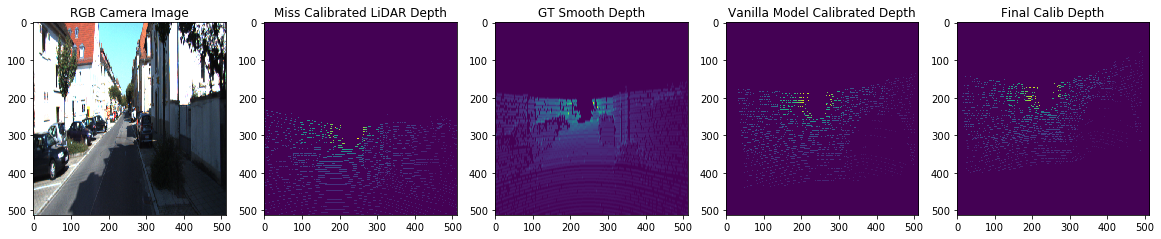

In [117]:
plt.figure(figsize=[20,20])
plt.subplot(151)
plt.title('RGB Camera Image')
plt.imshow(np.transpose(data_batch['img'][0,-1].cpu().numpy(), axes=(1,2,0))[..., ::-1])
plt.subplot(152)
plt.title('Miss Calibrated LiDAR Depth')
plt.imshow(data_batch['depth'][0,-1,0].cpu().numpy())
plt.subplot(153)
plt.title('GT Smooth Depth')
plt.imshow(data_batch['depth_gt'][0,-1,0].cpu().numpy())
plt.subplot(154)
plt.title('Vanilla Model Calibrated Depth')
plt.imshow(depth_out[0,0].detach().cpu().numpy())
depth_gt_final = transform_depth(depth_out, rtvec_to_matrix(pose_gt))
plt.subplot(155)
plt.title('Final Calib Depth')
plt.imshow(depth_gt_final[0,0].detach().cpu().numpy())

In [55]:
matrix_to_rtvec(rtvec_to_matrix(matrix_to_rtvec(rtvec_to_matrix(pose_gt) @ torch.inverse(extrinsic_ts))) @ extrinsic_ts)

tensor([[-0.0032,  0.0552, -0.0436,  0.4376,  0.3468,  0.0135],
        [-0.0261,  0.0806,  0.0718,  0.3603, -0.3141, -0.3419],
        [ 0.0644, -0.0297,  0.0797,  0.0695, -0.2981, -0.1881],
        [ 0.0633,  0.0037,  0.0086,  0.3102, -0.1172,  0.2245]],
       device='cuda:0', grad_fn=<CopySlices>)

In [58]:
pose_gt[0]

tensor([-0.0032,  0.0552, -0.0436,  0.4376,  0.3468,  0.0135], device='cuda:0')

In [31]:
matrix_to_rtvec(extrinsic_ts)

tensor([[-0.0014, -0.0010, -0.0325,  0.3856,  0.4452,  0.1749],
        [-0.0182,  0.0143,  0.0445,  0.0677, -0.2455, -0.2455],
        [ 0.0682,  0.0041,  0.0508, -0.0709, -0.3427, -0.1385],
        [ 0.0710, -0.0198,  0.0100, -0.0139, -0.1013,  0.4262]],
       device='cuda:0', grad_fn=<CopySlices>)

In [40]:
rtvec_to_matrix(pose_gt)

tensor([[[ 0.9975,  0.0435,  0.0552,  0.4376],
         [-0.0437,  0.9990,  0.0020,  0.3468],
         [-0.0550, -0.0044,  0.9985,  0.0135],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9942, -0.0727,  0.0795,  0.3603],
         [ 0.0706,  0.9971,  0.0289, -0.3141],
         [-0.0814, -0.0232,  0.9964, -0.3419],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9964, -0.0805, -0.0271,  0.0695],
         [ 0.0786,  0.9948, -0.0655, -0.2981],
         [ 0.0323,  0.0631,  0.9975, -0.1881],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 1.0000, -0.0085,  0.0040,  0.3102],
         [ 0.0087,  0.9980, -0.0632, -0.1172],
         [-0.0034,  0.0633,  0.9980,  0.2245],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0')

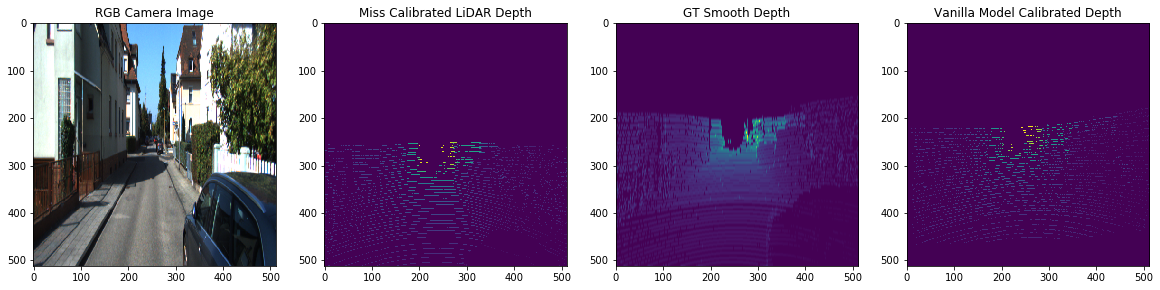

In [66]:
plt.figure(figsize=[20,20])
plt.subplot(141)
plt.title('RGB Camera Image')
plt.imshow(np.transpose(data_batch['img'][0,0].cpu().numpy(), axes=(1,2,0))[..., ::-1])
plt.subplot(142)
plt.title('Miss Calibrated LiDAR Depth')
plt.imshow(data_batch['depth'][0,0,0].cpu().numpy())
plt.subplot(143)
plt.title('GT Smooth Depth')
plt.imshow(data_batch['depth_gt'][0,0,0].cpu().numpy())
plt.subplot(144)
plt.title('Vanilla Model Calibrated Depth')
plt.imshow(depth_out[0,0].detach().cpu().numpy())

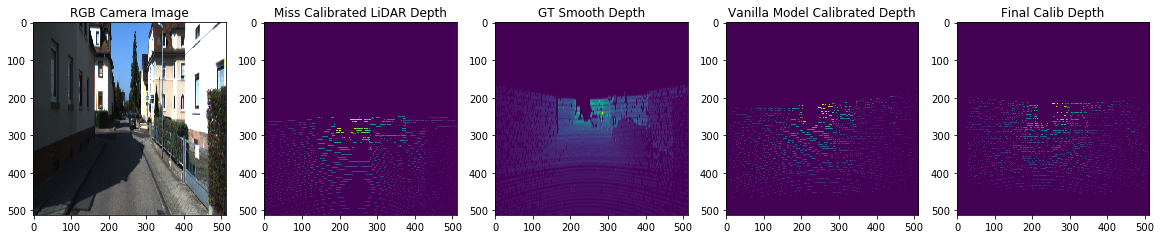

In [29]:
depth_ts = depth_out
extrinsic_ts = rtvec_to_matrix(pose_gt).view(B,4,4)
y = torch.arange(512)
x = torch.arange(512)
gridy, gridx = torch.meshgrid(x, y, indexing='ij')
# mask_batch = (data_batch['depth'] < 0.1)
gridx_batch = gridx.unsqueeze(0).unsqueeze(0).repeat([B,C,1,1]).cuda()
gridy_batch = gridy.unsqueeze(0).unsqueeze(0).repeat([B,C,1,1]).cuda()

uvz = torch.zeros((B,3,512,512), dtype=torch.float32).cuda()
# mask = (data_batch['depth'][0,0] == 0)[0]
uvz[:,0] = (gridx_batch * depth_ts)[:,0]
uvz[:,1] = (gridy_batch * depth_ts)[:,0]
uvz[:,2] = (depth_ts)[:,0]
points3d = (torch.inverse(data_batch['intrinsic'][:,frame_id]) @ uvz.reshape(B,3,-1))
points3d_hom = torch.cat((points3d, torch.ones(B, 1, points3d.shape[-1]).cuda()),dim=1)
projected = data_batch['intrinsic'][:,frame_id] @ (extrinsic_ts @ points3d_hom)[:,:3]
Z = projected[:,2,:]
Y = projected[:,1,:] / Z
X = projected[:,0,:] / Z
X = X.to(torch.int64); Y = Y.to(torch.int64)
depth_out = torch.zeros(B, C, H, W).cuda()
flag = (Y < W) & (Y > 0) & (X > 0) & (X < W)
flag_out_mean = torch.zeros(1).cuda()
# for b in range(B):
for b in range(B):
    flag_idx = flag[b]
    depth_out[b,:, Y[b, flag_idx],X[b, flag_idx]] = Z[b, flag_idx]    

# loss_linear = (data_batch['pose'][:,frame_id].view(B,6)/torch.pi - calib_out_tanh).abs().mean()
loss_linear = (pose_gt/torch.pi - calib_out_tanh).abs().mean()
loss_depth = (data_batch['depth_gt'][:,frame_id] - depth_out).abs().mean()

# pose_gt = matrix_to_rtvec(rtvec_to_matrix(data_batch['pose'][:,frame_id].view(B,6)) @ torch.inverse(extrinsic_ts))


loss = loss_depth + loss_linear * 20
loss_list.append(loss.detach().cpu().numpy())
print(f'loss : {loss}, linear : {loss_linear}, depth : {loss_depth}', end='\r')

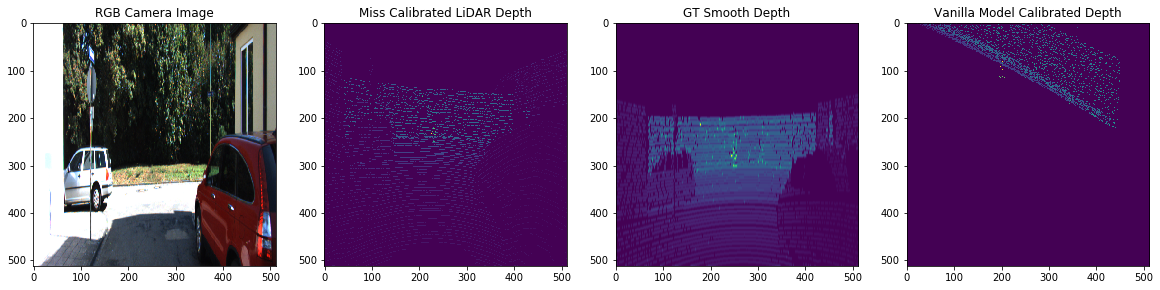

In [30]:
plt.figure(figsize=[20,20])
plt.subplot(141)
plt.title('RGB Camera Image')
plt.imshow(np.transpose(data_batch['img'][0,0].cpu().numpy(), axes=(1,2,0))[..., ::-1])
plt.subplot(142)
plt.title('Miss Calibrated LiDAR Depth')
plt.imshow(data_batch['depth'][0,0,0].cpu().numpy())
plt.subplot(143)
plt.title('GT Smooth Depth')
plt.imshow(data_batch['depth_gt'][0,0,0].cpu().numpy())
plt.subplot(144)
plt.title('Vanilla Model Calibrated Depth')
plt.imshow(depth_out[0,0].detach().cpu().numpy())

In [56]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points3d[0].detach().cpu().numpy().T)
o3d.visualization.draw_geometries([pcd])

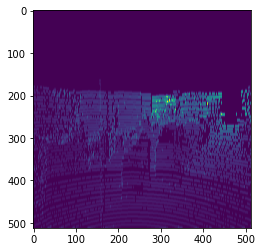

In [57]:
plt.imshow(data_batch['depth_gt'][:,frame_id][0,0].detach().cpu().numpy())

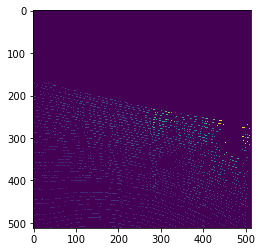

In [58]:
plt.imshow(depth_out[0,0].detach().cpu().numpy())

In [69]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(uvz.numpy().reshape(512*512,3))
o3d.visualization.draw_geometries([pcd])

(torch.Size([4, 262144]),
 torch.Size([4, 262144]),
 torch.Size([4, 10, 1, 512, 512]))

In [173]:
points3d.shape

torch.Size([4, 3, 262144])

In [23]:
# import torchgeometry as tgm
# from torch import optim
# model = CalibNet()
# optimizer = optim.Adam(model.parameters(), lr=0.01)
model.train()
model.cuda()
loss_list = []
data_batch = next(it)
for key in data_batch.keys():
    data_batch[key] = data_batch[key].cuda()
model.zero_grad()
B, S, C, H, W = data_batch['depth'].shape
calib_out = model(data_batch['img'].view(B*S, 3, H, W), data_batch['depth'].view(B*S, 1, H, W))    
extrinsic_ts = tgm.rtvec_to_pose(torch.tanh(calib_out) * torch.pi).view(B,S,4,4)
B, S, C, H, W = data_batch['depth'].shape
y = torch.arange(512)
x = torch.arange(512)
gridy, gridx = torch.meshgrid(x, y, indexing='ij')
mask_batch = (data_batch['depth'] < 0.1)
gridx_batch = gridx.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat([B,S,C,1,1]).cuda()
gridy_batch = gridy.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat([B,S,C,1,1]).cuda()

uvz = torch.zeros((B,S,3,512,512), dtype=torch.float32).cuda()
mask = (data_batch['depth'][0,0] == 0)[0]
uvz[:,:,0] = (gridx_batch * data_batch['depth'])[:,:,0]
uvz[:,:,1] = (gridy_batch * data_batch['depth'])[:,:,0]
uvz[:,:,2] = (data_batch['depth'])[:,:,0]
points3d = (torch.inverse(data_batch['intrinsic']) @ uvz.reshape(B,S,3,-1))
points3d_hom = torch.cat((points3d, torch.ones(B, S, 1, points3d.shape[-1]).cuda()),dim=2)
projected = data_batch['intrinsic'] @ (extrinsic_ts @ points3d_hom)[:,:,:3]
Z = projected[:,:,2,:]
Y = projected[:,:,1,:] / Z
X = projected[:,:,0,:] / Z
X = X.to(torch.int64); Y = Y.to(torch.int64)
depth_out = torch.zeros(B, S, C, H, W).cuda()
flag = (Y < W) & (Y > 0) & (X > 0) & (X < W)
flag_out_mean = torch.zeros(1).cuda()
for b in range(B):
    for s in range(S):
        flag_idx = flag[b,s]
        flag_out = Z[b,s,~flag_idx]
        flag_out_mean = flag_out_mean + flag_out.abs().mean()
        depth_out[b,s,0,Y[b, s, flag_idx],X[b,s,flag_idx]] = Z[b,s,flag_idx]
loss_linear = (data_batch['pose'].view(B*S,6)/torch.pi - calib_out).abs().mean()
loss_depth = (data_batch['depth_gt'] - depth_out).abs().mean()
loss_proj = 1 / depth_out.mean()
loss = loss_linear * 10 + loss_depth
loss.backward()
optimizer.step()
loss_list.append(loss.detach().cpu().numpy())
print(f'loss : {loss}', end='\r')

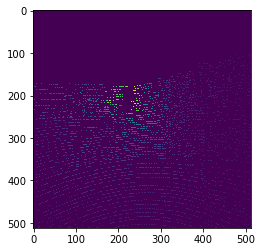

In [146]:
plt.imshow(depth_out[0,0,0].detach().cpu().numpy())

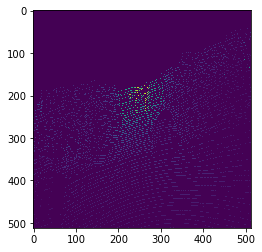

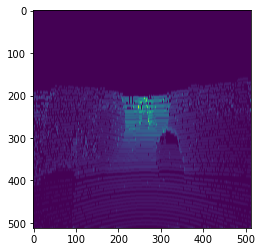

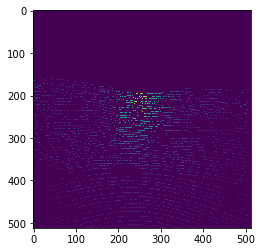

In [24]:
plt.figure()
plt.imshow(data_batch['depth'][0,0,0].cpu().numpy())
plt.figure()
plt.imshow(data_batch['depth_gt'][0,0,0].cpu().numpy())
plt.figure()
plt.imshow(depth_out[0,0,0].detach().cpu().numpy())

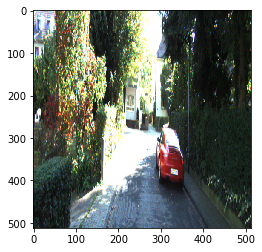

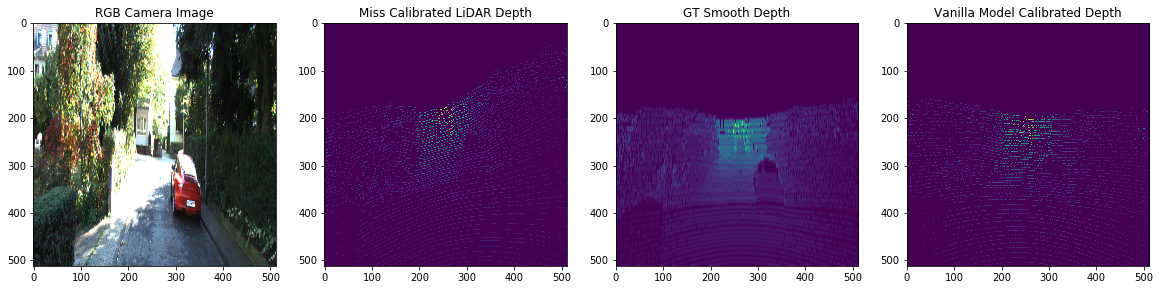

In [36]:
plt.figure(figsize=[20,20])
plt.subplot(141)
plt.title('RGB Camera Image')
plt.imshow(np.transpose(data_batch['img'][0,0].cpu().numpy(), axes=(1,2,0))[..., ::-1])
plt.subplot(142)
plt.title('Miss Calibrated LiDAR Depth')
plt.imshow(data_batch['depth'][0,0,0].cpu().numpy())
plt.subplot(143)
plt.title('GT Smooth Depth')
plt.imshow(data_batch['depth_gt'][0,0,0].cpu().numpy())
plt.subplot(144)
plt.title('Vanilla Model Calibrated Depth')
plt.imshow(depth_out[0,0,0].detach().cpu().numpy())

In [29]:
depth_out[0,0,0].max()

tensor(79.7153, grad_fn=<MaxBackward1>)

## Rubish

In [18]:
data_batch['img'].shape, data_batch['depth'].shape, data_batch['img'].dtype, data_batch['depth'].dtype

(torch.Size([4, 10, 3, 512, 512]),
 torch.Size([4, 10, 1, 512, 512]),
 torch.float32,
 torch.float32)

In [19]:
B, S, C, H, W = data_batch['depth'].shape
depth_out = CalibResnet(in_channels=C)(data_batch['depth'].view(B*S, C, H, W))
depth_out.shape

torch.Size([40, 256, 32, 32])

In [20]:
B, S, C, H, W = data_batch['img'].shape
img_out = CalibResnet(in_channels=C)(data_batch['img'].view(B*S, C, H, W))
img_out.shape

torch.Size([40, 256, 32, 32])

In [23]:
calib_out = CalibNet()(data_batch['img'].view(B*S, 3, H, W), data_batch['depth'].view(B*S, 1, H, W))
calib_out.shape

torch.Size([40, 6])

In [24]:
import torchgeometry as tgm
extrinsic_ts = tgm.rtvec_to_pose(torch.tanh(calib_out) * torch.pi).view(B,S,4,4)

In [38]:
B, S, C, H, W = data_batch['depth'].shape
y = torch.arange(512)
x = torch.arange(512)
gridy, gridx = torch.meshgrid(x, y, indexing='ij')
mask_batch = (data_batch['depth'] < 0.1)
gridx_batch = gridx.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat([B,S,C,1,1])
gridy_batch = gridy.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat([B,S,C,1,1])

uvz = torch.zeros((B,S,3,512,512), dtype=torch.float32)
mask = (data_batch['depth'][0,0] == 0)[0]
uvz[:,:,0] = (gridx_batch * data_batch['depth'])[:,:,0]
uvz[:,:,1] = (gridy_batch * data_batch['depth'])[:,:,0]
uvz[:,:,2] = (data_batch['depth'])[:,:,0]
points3d = (torch.inverse(data_batch['intrinsic']) @ uvz.reshape(B,S,3,-1))
points3d_hom = torch.cat((points3d, torch.ones(B, S, 1, points3d.shape[-1])),dim=2)
projected = data_batch['intrinsic'] @ (extrinsic_ts @ points3d_hom)[:,:,:3]
Z = projected[:,:,2,:]
Y = projected[:,:,1,:] / Z
X = projected[:,:,0,:] / Z
X = X.to(torch.int64); Y = Y.to(torch.int64)
depth_out = torch.zeros(B, S, C, H, W)
flag = (Y < W) & (Y > 0) & (X > 0) & (X < W)
for b in range(B):
    for s in range(S):
        flag_idx = flag[b,s]
        depth_out[b,s,0,Y[b, s, flag_idx],X[b,s,flag_idx]] = Z[b,s,flag_idx]
loss = (data_batch['depth_gt'] - depth_out).square().mean()
loss


tensor(41.5379, grad_fn=<MeanBackward0>)

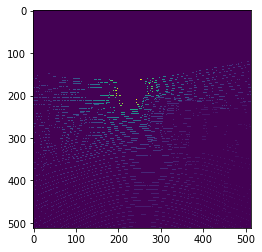

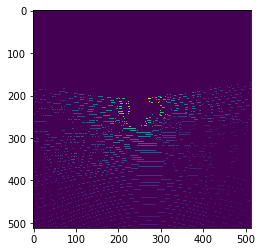

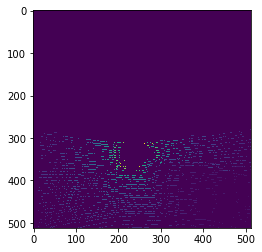

In [39]:
plt.figure()
plt.imshow(data_batch['depth'][0,0,0].cpu().numpy())
plt.figure()
plt.imshow(data_batch['depth_gt'][0,0,0].cpu().numpy())
plt.figure()
plt.imshow(depth_out[0,0,0].detach().cpu().numpy())

In [37]:
B, S, C, H, W = data_batch['depth'].shape
y = torch.arange(512)
x = torch.arange(512)
gridy, gridx = torch.meshgrid(x, y, indexing='ij')
mask_batch = (data_batch['depth'] < 0.1)
gridx_batch = gridx.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat([B,S,C,1,1])
gridy_batch = gridy.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat([B,S,C,1,1])

uvz = torch.zeros((B,S,3,512,512), dtype=torch.float32)
mask = (data_batch['depth'][0,0] == 0)[0]
uvz[:,:,0] = (gridx_batch * data_batch['depth'])[:,:,0]
uvz[:,:,1] = (gridy_batch * data_batch['depth'])[:,:,0]
uvz[:,:,2] = (data_batch['depth'])[:,:,0]
points3d = (torch.inverse(data_batch['intrinsic']) @ uvz.reshape(B,S,3,-1))
points3d_hom = torch.cat((points3d, torch.ones(B, S, 1, points3d.shape[-1])),dim=2)
projected = data_batch['intrinsic'] @ (torch.inverse(data_batch['extrinsic']) @ points3d_hom)[:,:,:3]
Z = projected[:,:,2,:]
Y = projected[:,:,1,:] / Z
X = projected[:,:,0,:] / Z
X = X.to(torch.int64); Y = Y.to(torch.int64)
depth_out = torch.zeros(B, S, C, H, W)
flag = (Y < W) & (Y > 0) & (X > 0) & (X < W)
for b in range(B):
    for s in range(S):
        flag_idx = flag[b,s]
        depth_out[b,s,0,Y[b, s, flag_idx],X[b,s,flag_idx]] = Z[b,s,flag_idx]

loss = (data_batch['depth_gt'] - depth_out).square().mean()
loss


tensor(26.9151)

In [33]:
data_batch['extrinsic'][0]

tensor([[[ 0.9981,  0.0081, -0.0604, -0.4321],
         [-0.0109,  0.9989, -0.0458,  0.0406],
         [ 0.0600,  0.0463,  0.9971,  0.4206],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9987,  0.0032, -0.0516, -0.2348],
         [-0.0064,  0.9980, -0.0631, -0.2276],
         [ 0.0512,  0.0633,  0.9967, -0.4363],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9984,  0.0414, -0.0392,  0.1250],
         [-0.0443,  0.9959, -0.0791, -0.1403],
         [ 0.0357,  0.0807,  0.9961,  0.2168],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9978, -0.0085, -0.0662,  0.0072],
         [ 0.0039,  0.9976, -0.0698, -0.2367],
         [ 0.0666,  0.0694,  0.9954, -0.1992],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9959,  0.0713,  0.0561,  0.2736],
         [-0.0722,  0.9973,  0.0144, -0.0346],
         [-0.0549, -0.0184,  0.9983,  0.0862],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.9987, -0.0010,  0.0512, -0.4588],
   

In [34]:
(data_batch['depth_gt'] - depth_out).square().mean()

tensor(26.9153)

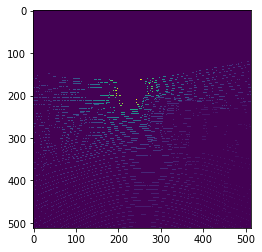

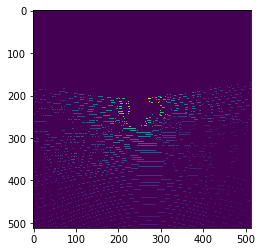

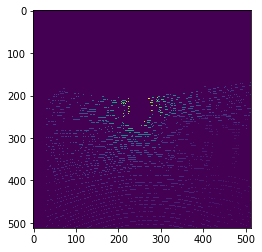

In [35]:
plt.figure()
plt.imshow(data_batch['depth'][0,0,0].cpu().numpy())
plt.figure()
plt.imshow(data_batch['depth_gt'][0,0,0].cpu().numpy())
plt.figure()
plt.imshow(depth_out[0,0,0].detach().cpu().numpy())

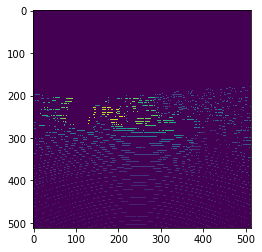

In [273]:
plt.figure()
plt.imshow(data_batch['depth'][0,0,0].numpy())
plt.figure()
plt.imshow(data_batch['depth_gt'][0,0,0].numpy())
plt.figure()
plt.imshow(depth_out[0,0,0].numpy())

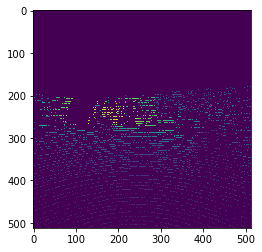

In [30]:
data_batch['depth'][0,0].shape

torch.Size([1, 512, 512])

In [31]:
(data_batch['depth'][0,0] > 0).shape

torch.Size([1, 512, 512])

In [32]:
data_batch['intrinsic'][0,0]

tensor([[296.5788,   0.0000, 250.5098],
        [  0.0000, 978.8677, 252.2086],
        [  0.0000,   0.0000,   1.0000]])

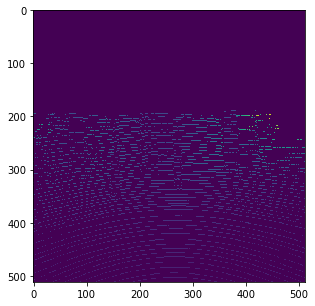

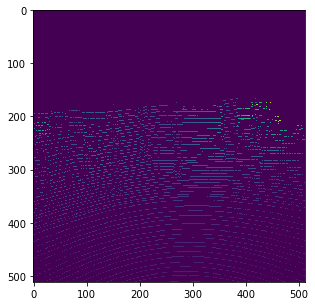

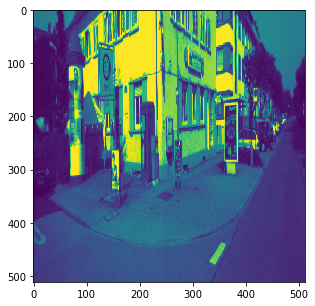

In [35]:
plt.figure(figsize=[5,5])
plt.imshow(data_batch['depth_gt'][0,0,0])
plt.figure(figsize=[5,5])
plt.imshow(data_batch['depth'][0,0,0])
plt.figure(figsize=[5,5])
plt.imshow(data_batch['img'][0,0,0])

In [210]:
uvz[:,:,0] = (gridx_batch * data_batch['depth'])[:,:,0]

In [211]:
B, S, C, H, W = data_batch['depth'].shape
y = torch.arange(512)
x = torch.arange(512)
gridy, gridx = torch.meshgrid(x, y, indexing='ij')
mask_batch = (data_batch['depth'] < 0.1)
gridx_batch = gridx.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat([B,S,C,1,1])
gridy_batch = gridy.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat([B,S,C,1,1])

uvz = torch.zeros((B,S,3,512,512), dtype=torch.float32)
mask = (data_batch['depth'][0,0] == 0)[0]
uvz[:,:,0] = (gridx_batch * data_batch['depth'])[:,:,0]
uvz[:,:,1] = (gridy_batch * data_batch['depth'])[:,:,0]
uvz[:,:,2] = (data_batch['depth'])[:,:,0]
points3d = (torch.inverse(data_batch['intrinsic']) @ uvz.reshape(B,S,3,-1))
points3d_hom = torch.cat((points3d, torch.ones(B, S, 1, points3d.shape[-1])),dim=2)
projected = data_batch['intrinsic'] @ (torch.inverse(data_batch['extrinsic']) @ points3d_hom)[:,:,:3]
Z = projected[:,:,2,:]
Y = projected[:,:,1,:] / Z
X = projected[:,:,0,:] / Z
X = X.to(torch.int64); Y = Y.to(torch.int64)
depth_out = torch.zeros(B, S, C, H, W)
flag = (Y < W) & (Y > 0) & (X > 0) & (X < W)
for b in range(B):
    for s in range(S):
        flag_idx = flag[b,s]
        depth_out[b,s,0,Y[b, s, flag_idx],X[b,s,flag_idx]] = Z[b,s,flag_idx]



In [169]:
X.shape

torch.Size([8, 10, 3, 262144])

In [213]:
y = torch.arange(512)
x = torch.arange(512)
gridy, gridx = torch.meshgrid(x, y, indexing='ij')
uvz = torch.zeros((3,512,512))
mask = (data_batch['depth'][0,0] == 0)[0]
uvz[0] = gridx * data_batch['depth'][0,0]
uvz[1] = gridy * data_batch['depth'][0,0]
uvz[2] = data_batch['depth'][0,0]
points3d = (torch.inverse(data_batch['intrinsic'][0,0]) @ uvz.reshape(3,512*512))
points3d_hom = torch.cat((points3d, torch.ones(1, points3d.shape[-1])))
projected = data_batch['intrinsic'][0,0] @ (torch.inverse(data_batch['extrinsic'][0,0]) @ points3d_hom)[:3, :]
projected = projected.reshape(3, 512, 512)
Z = projected[2, ...]
projected = projected / Z
projected[:, mask] = 0
X = projected[0].reshape(-1).to(torch.int64); Y = projected[1].reshape(-1).to(torch.int64); Z = Z.reshape(-1)

depth = torch.zeros(512,512)
flag = (Y < 512) & (Y > 0) & (X > 0) & (X < 512)
X = X[flag];Y = Y[flag];Z = Z[flag];
depth[Y,X] = Z
# depth = projected.reshape(3,512,512)[2, ...]
# data_batch['depth_gt'][0,0].shape


In [214]:
flag.sum()

tensor(19370)

In [120]:
(depth - data_batch['depth_gt'][0,0]).sum()

tensor(-1736.8708)

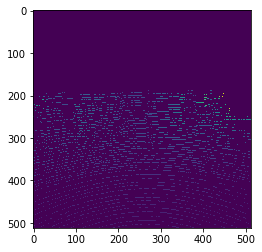

In [246]:
plt.imshow(depth.numpy())

In [84]:
B, S, C, H, W = data_batch['depth'].shape
gridy, gridx = torch.meshgrid(x, y, indexing='ij')
mask_batch = (data_batch['depth'] < 0.1)
gridx_batch = gridx.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat([B,S,C,1,1])
gridy_batch = gridy.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat([B,S,C,1,1])
fx = data_batch['intrinsic'][:,:,0,0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
fy = data_batch['intrinsic'][:,:,1,1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
cx = data_batch['intrinsic'][:,:,0,2].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
cy = data_batch['intrinsic'][:,:,1,2].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
uvz = torch.zeros((B,S,C,512,512,3))
uvz[...,0] = ((gridx_batch - cx)*data_batch['depth'] / fx)
uvz[...,1] = ((gridy_batch - cy)*data_batch['depth'] / fy)
uvz[mask_batch] = 0
uvz[...,2] = data_batch['depth'][0,0]

In [72]:
(gridx_batch - cx).shape, data_batch['depth'].shape

(torch.Size([8, 10, 1, 512, 512]), torch.Size([8, 10, 1, 512, 512]))

In [79]:
((gridx_batch - cx)*data_batch['depth']/fx).shape

torch.Size([8, 10, 1, 512, 512])

In [52]:
B, S

(8, 10)

In [37]:
gridy, gridx = torch.meshgrid(x, y, indexing='ij')
mask = (data_batch['depth'][0,0] < 0.1)[0]
uvz = torch.zeros((512,512,3))
fx = data_batch['intrinsic'][0,0,0,0]
fy = data_batch['intrinsic'][0,0,1,1]
cx = data_batch['intrinsic'][0,0,0,2]
cy = data_batch['intrinsic'][0,0,1,2]
uvz[...,0] = ((gridx - cx)*data_batch['depth'][0,0] / fx)
uvz[...,1] = ((gridy - cy)*data_batch['depth'][0,0] / fy)
# uvz[...,0] = gridx
# uvz[...,1] = gridy
uvz[mask] = 0
uvz[...,2] = data_batch['depth'][0,0]
fx,fy,cx,cy

(tensor(296.5788), tensor(978.8677), tensor(250.5098), tensor(252.2086))

In [38]:
uvz[..., 2].max()

tensor(68.0027)

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(uvz.numpy().reshape(512*512,3))
o3d.visualization.draw_geometries([pcd])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points3d.numpy().T)
o3d.visualization.draw_geometries([pcd])

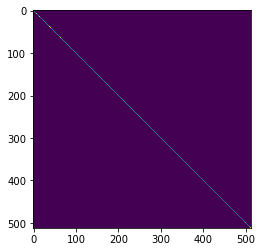

In [41]:
X = projected[0].to(torch.int64).reshape(-1)
x_mask = (X > 0) & (X < 512)
X = X[x_mask]
Y = projected[0].to(torch.int64).reshape(-1)
y_mask = (Y > 0) & (Y < 512)
Y = Y[y_mask]
depth = torch.zeros(512,512)
depth[Y, X] = Z.reshape(-1)[x_mask & y_mask]
plt.imshow(depth)

In [283]:
(uvz - projected.reshape(3, 512,512)).sum()

tensor(-0.0167)

In [267]:
depth[(data_batch['depth'][0,0] == 0)[0]] = 0

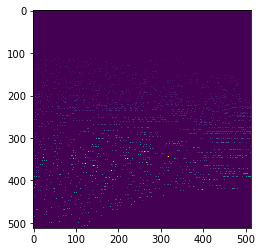

In [274]:
plt.imshow(depth)

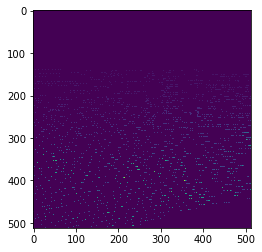

In [275]:
plt.imshow(data_batch['depth_gt'][0,0][0])

In [276]:
data_batch['depth_gt'][0,0][0].max()

tensor(73.0754)

In [277]:
depth.max()

tensor(81.0757)

In [284]:
(depth - data_batch['depth_gt'][0,0][0]).sum()

tensor(-5113.7173)

In [259]:
projected

tensor([[115.8812, 115.8812, 115.8812,  ..., 115.8812, 115.8812, 115.8812],
        [418.4003, 418.4003, 418.4003,  ..., 418.4003, 418.4003, 418.4003],
        [  0.5245,   0.5245,   0.5245,  ...,   0.5245,   0.5245,   0.5245]])

In [239]:
data_batch['intrinsic'][0,0]

tensor([[718.8560,   0.0000, 607.1928],
        [  0.0000, 718.8560, 185.2157],
        [  0.0000,   0.0000,   1.0000]])

In [240]:
torch.inverse(data_batch['intrinsic'][0,0])

tensor([[ 0.0014,  0.0000, -0.8447],
        [ 0.0000,  0.0014, -0.2577],
        [ 0.0000,  0.0000,  1.0000]])

In [236]:
projected

tensor([[-0.2818, -0.2818, -0.2818,  ..., -0.2818, -0.2818, -0.2818],
        [ 0.4469,  0.4469,  0.4469,  ...,  0.4469,  0.4469,  0.4469],
        [ 0.5245,  0.5245,  0.5245,  ...,  0.5245,  0.5245,  0.5245]])

In [206]:
depth - data_batch['depth_gt'][0,0][0]

tensor([[0.5245, 0.5245, 0.5245,  ..., 0.5245, 0.5245, 0.5245],
        [0.5245, 0.5245, 0.5245,  ..., 0.5245, 0.5245, 0.5245],
        [0.5245, 0.5245, 0.5245,  ..., 0.5245, 0.5245, 0.5245],
        ...,
        [0.5245, 0.5245, 0.5245,  ..., 0.5245, 0.5245, 0.5245],
        [0.5245, 0.5245, 0.5245,  ..., 0.5245, 0.5245, 0.5245],
        [0.5245, 0.5245, 0.5245,  ..., 0.5245, 0.5245, 0.5245]])

In [182]:
points3d.shape

torch.Size([3, 262144])

In [178]:
data_batch['intrinsic'][0,0].dtype

torch.float32

In [179]:
uvz.reshape(3,512*512).dtype

torch.float32

In [164]:
torch.inverse(data_batch['intrinsic'][0,0]).dtype

torch.float64